**Blok 1: Import Library**

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import copy
from collections import Counter

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.transforms import v2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


**Blok 2: Cek GPU dan Setup Device**

In [ ]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
  current_device = torch.cuda.current_device()
  gpu_properties = torch.cuda.get_device_properties(current_device)
  print(f"GPU Name: {gpu_properties.name}")
  print(f"GPU Memory: {gpu_properties.total_memory / 1024**3:.2f} GB")
  print(f"GPU Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
else:
  print("No GPU available, using CPU")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.00 GB
GPU Compute Capability: 8.9

Using device: cuda


**Blok 3: Setup Path dan Parameters**

In [3]:
# Define dataset paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Check if directories exist
print("Checking dataset structure...")
if os.path.exists(train_dir) and os.path.exists(test_dir):
  train_classes = os.listdir(train_dir)
  test_classes = os.listdir(test_dir)
  print(f"Train classes: {train_classes}")
  print(f"Test classes: {test_classes}")
    
  # Count number of images per class
  print("\nNumber of images per class in train set:")
  for class_name in train_classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")

  print("\nNumber of images per class in test set:")
  for class_name in test_classes:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")
else:
  print(f"Error: Dataset directories not found!")
  print(f"Train directory: {train_dir}")
  print(f"Test directory: {test_dir}")

# Training parameters
batch_size = 64
num_epochs = 50
num_classes = 7

Checking dataset structure...
Train classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Number of images per class in train set:
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images

Number of images per class in test set:
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  neutral: 1233 images
  sad: 1247 images
  surprise: 831 images


**Blok 4: Data Transforms dan Augmentation**

In [4]:
# Enhanced data transformations with heavy augmentation
train_transform = v2.Compose([
  v2.Resize((224, 224)),  # Resize for ResNet
  v2.RandomHorizontalFlip(p=0.5),
  v2.RandomRotation(degrees=15),
  v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
  v2.ColorJitter(brightness=0.2, contrast=0.2),
  v2.RandomGrayscale(p=0.1),
  v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform  # Same as validation transform

print("Data transforms defined successfully!")

Data transforms defined successfully!


**Blok 5: Load Dataset dengan ImageFolder**

In [5]:
# Load datasets using ImageFolder
print("Loading datasets...")

try:
  train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    
  # Get class names
  class_names = train_dataset.classes
  print(f"Class names: {class_names}")
  print(f"Number of classes: {len(class_names)}")

  print(f"Training samples: {len(train_dataset)}")
  print(f"Test samples: {len(test_dataset)}")
    
  # Split train into train and validation (90% train, 10% validation)
  train_size = int(0.9 * len(train_dataset))
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
  )
    
  # Apply validation transform to validation set
  val_dataset.dataset = copy.deepcopy(val_dataset.dataset)
  val_dataset.dataset.transform = val_transform

  print(f"After split - Training samples: {len(train_dataset)}")
  print(f"After split - Validation samples: {len(val_dataset)}")
  print(f"After split - Test samples: {len(test_dataset)}")

except Exception as e:
  print(f"Error loading datasets: {e}")
  # Create dummy datasets for demonstration if real datasets not available
  from torchvision.datasets import FakeData

  train_dataset = FakeData(size=28000, image_size=(3, 48, 48), num_classes=7, 
                        transform=train_transform)
  val_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=val_transform)
  test_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=test_transform)
  class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

Loading datasets...
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7
Training samples: 28709
Test samples: 7178
After split - Training samples: 25838
After split - Validation samples: 2871
After split - Test samples: 7178


**Blok 6: Create DataLoaders dan Calculate Class Weights**

DataLoaders created successfully!
Batch size: 64
Number of training batches: 404
Number of validation batches: 45
Number of test batches: 113

Class distribution:
  angry: 3619 samples
  disgust: 392 samples
  fear: 3673 samples
  happy: 6483 samples
  neutral: 4455 samples
  sad: 4356 samples
  surprise: 2860 samples

Class weights: tensor([1.0199, 9.4162, 1.0049, 0.5694, 0.8285, 0.8474, 1.2906],
       device='cuda:0')


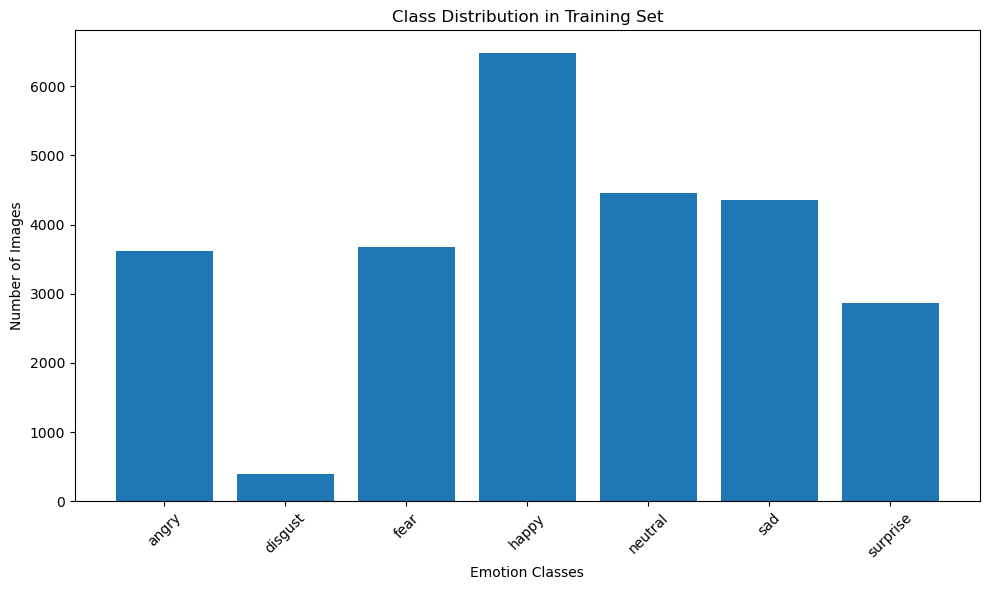

In [6]:
# Create data loaders with optimal settings
train_loader = DataLoader(
  train_dataset, 
  batch_size=batch_size, 
  shuffle=True, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
  val_dataset, 
  batch_size=batch_size, 
  shuffle=False, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
  test_dataset, 
  batch_size=batch_size, 
  shuffle=False, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Calculate class weights for imbalanced data
def calculate_class_weights(loader, num_classes=7):
  class_counts = torch.zeros(num_classes)
  for _, labels in loader:
    for i in range(num_classes):
      class_counts[i] += (labels == i).sum()
    
  total = class_counts.sum()
  class_weights = total / (num_classes * class_counts)
  return class_counts, class_weights

class_counts, class_weights = calculate_class_weights(train_loader, num_classes)
class_weights = class_weights.to(device)

print("\nClass distribution:")
for i, class_name in enumerate(class_names):
  print(f"  {class_name}: {class_counts[i]:.0f} samples")

print(f"\nClass weights: {class_weights}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts.cpu().numpy())
plt.title('Class Distribution in Training Set')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Blok 7: Load Pretrained ResNet50 dan Modifikasi**

In [7]:
class EmotionResNet50(nn.Module):
  def __init__(self, num_classes=7, dropout_rate=0.5):
    super(EmotionResNet50, self).__init__()
        
    # Load pretrained ResNet50
    self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
    # Freeze early layers (first 4 blocks)
    for name, param in self.backbone.named_parameters():
      if 'layer1' in name or 'layer2' in name or 'layer3' in name:
        param.requires_grad = False
      else:
        param.requires_grad = True
        
    # Replace the final fully connected layer
    in_features = self.backbone.fc.in_features
        
    self.backbone.fc = nn.Sequential(
      nn.Dropout(p=dropout_rate),
      nn.Linear(in_features, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_rate-0.2),
      nn.Linear(1024, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_rate-0.3),
      nn.Linear(512, num_classes)
    )
        
    # Initialize the new layers
    self._initialize_weights(self.backbone.fc)
    
  def _initialize_weights(self, module):
    for m in module.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
  def forward(self, x):
    return self.backbone(x)

# Initialize model
model = EmotionResNet50(num_classes=num_classes, dropout_rate=0.5)
model = model.to(device)

print("Model initialized successfully!")
print(f"Model architecture: ResNet50")
print(f"Number of classes: {num_classes}")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Model summary
print("\nModel Structure:")
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100.0%


Model initialized successfully!
Model architecture: ResNet50
Number of classes: 7
Total parameters: 26,137,671
Trainable parameters: 17,603,911

Model Structure:
EmotionResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

**Blok 8: Define Loss Function, Optimizer, dan Scheduler**

In [8]:
# Loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with different learning rates for different parts
optimizer = optim.AdamW([
  {'params': model.backbone.conv1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.bn1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer2.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer3.parameters(), 'lr': 1e-4},
  {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
  {'params': model.backbone.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.OneCycleLR(
  optimizer, 
  max_lr=[1e-5, 1e-5, 1e-5, 1e-5, 1e-4, 1e-4, 1e-3],
  epochs=num_epochs,
  steps_per_epoch=len(train_loader),
  pct_start=0.1,
  div_factor=10.0,
  final_div_factor=100.0
)

print("Optimizer and scheduler defined successfully!")

Optimizer and scheduler defined successfully!


**Blok 9: Training Functions**

In [ ]:
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
    
  for batch_idx, (images, emotions) in enumerate(loader):
    images, emotions = images.to(device), emotions.to(device)
        
    # Zero gradients
    optimizer.zero_grad()
        
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, emotions)
        
    # Backward pass
    loss.backward()
        
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
    # Update weights
    optimizer.step()
    scheduler.step()
        
    # Statistics
    running_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == emotions).sum().item()
    total_samples += emotions.size(0)
        
    if batch_idx % 100 == 0:
      current_lr = scheduler.get_last_lr()[0]
      print(f'  Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.2e}')
    
  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
    
  return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  all_preds = []
  all_labels = []
    
  with torch.no_grad():
    for images, emotions in loader:
      images, emotions = images.to(device), emotions.to(device)
            
      outputs = model(images)
      loss = criterion(outputs, emotions)
            
      running_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == emotions).sum().item()
      total_samples += emotions.size(0)
            
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(emotions.cpu().numpy())
    
  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
    
  return epoch_loss, epoch_acc, all_preds, all_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
  since = time.time()
    
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_epoch = 0
    
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
    
  for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print('-' * 60)
        
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    # Validation phase
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
        
    current_lr = scheduler.get_last_lr()[0]
        
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Learning Rate: {current_lr:.2e}')
        
    # Save best model
    if val_acc > best_acc:
      best_acc = val_acc
      best_epoch = epoch
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), 'best_emotion_model.pth')
      print(f'*** New best model saved! Validation Accuracy: {val_acc:.4f} ***')
        
    print()
    
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best Validation Accuracy: {best_acc:.4f} at epoch {best_epoch + 1}')
    
  # Load best model weights
  model.load_state_dict(best_model_wts)
    
  return model, {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
  }

**Blok 10: Training Execution**

In [2]:
print("Starting training...")
print("=" * 60)

# Train the model
model, history = train_model(
  model, train_loader, val_loader, criterion, 
  optimizer, scheduler, device, num_epochs
)

print("Training completed!")

Starting training...


NameError: name 'model' is not defined